In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('names.txt', 'r') as fp:
    words = fp.read().splitlines()
    
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set("".join(words))))
char_to_i = {char:i+1 for i, char in enumerate(chars)}
char_to_i['.'] = 0
i_to_char = {i:s for s, i in char_to_i.items()}
print(i_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
ngram = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * ngram
        for ch in w + '.':
            ix = char_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
vocab_len = len(i_to_char)
embed_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_len, embed_dim), generator=g)
W1 = torch.randn((embed_dim * ngram, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim, vocab_len), generator=g) * 0.01
b2 = torch.randn(vocab_len, generator=g) * 0


parameters = [C, W1, b1, W2, b2]
print(f"num params: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

num params: 11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    idxs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X, Y = X_train[idxs], Y_train[idxs]
    # print(C.shape, X.shape, C[X].shape)
    emb = C[X]
    emb_concat = emb.view(emb.shape[0], -1)
    h = emb_concat @ W1 + b1
    # print(emb_concat.shape)
    a = torch.tanh(h)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
        
    if i%10000 == 0:
        print(f"{i}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break

0/200000: 3.6643


(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

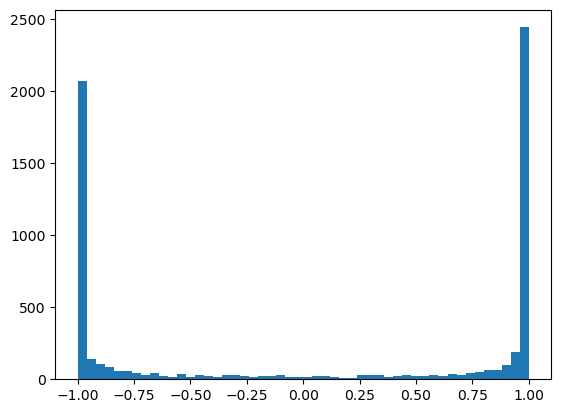

In [8]:
plt.hist(a.view(-1).tolist() , 50)

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

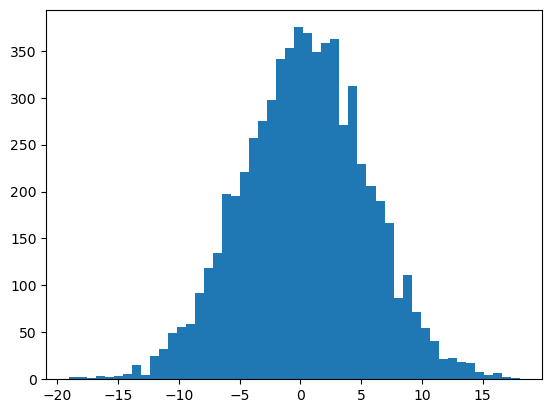

In [9]:
plt.hist(h.view(-1).tolist() , 50)

In [ ]:
plt.plot(lossi)

### Split loss

In [ ]:
@torch.no_grad()

def split_loss(split):
    X, Y = {
            'train': (X_train, Y_train),
            'dev': (X_dev, Y_dev),
            'test': (X_test, Y_test)
           }[split]

    emb = C[X]
    emb_concat = emb.view(emb.shape[0], -1)
    # print(emb_concat.shape)
    h1 = torch.tanh(emb_concat @ W1 + b1)
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split}: {loss.item(): .4f}")
    
split_loss('train')
split_loss('dev')

### Sample

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * ngram
    while True:
        emb = C[torch.tensor(context)]
        h1 = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h1 @ W2 + b2
        # counts = logits.exp()
        # probs = counts/counts.sum(dim=1, keepdims=True)
        probs = F.softmax(logits, dim=1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [next_idx]
        out.append(i_to_char[next_idx])
        if next_idx == 0:
            break
    print(''.join(out))      
        
    